# IMPORTS

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score


## LEITURA DOS DADOS

In [3]:
df = pd.read_csv('/home/cid34senhas/Desktop/DAATP/process/1_Processamento/100./1_1_Processamento/df_colunasRFE_removidas.csv') 
df_test = pd.read_csv('/home/cid34senhas/Desktop/DAATP/process/1_Processamento/100./1_1_Processamento/df_test_colunasRFE_removidas.csv')

label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
    'CN-MCI' : 4
}


## Devisão Origem e Destino

In [4]:


label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
    'CN-MCI' : 4
}

# Criar o dicionário de reverse mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Aplicar o reverse mapping à coluna Transition
df['Transition'] = df['Transition'].map(reverse_label_mapping)

df['Transition'] = df['Transition'].astype(str)

df[['Origem', 'Destino']] = df['Transition'].str.split('-', expand=True)

In [5]:
from sklearn.calibration import LabelEncoder


def gerar_origem(df, modelo, feature_importance_threshold, test_size=0.40, random_state=34, cv_folds=5):
    """
    Realiza seleção de features e avalia o modelo fornecido.
    
    Parâmetros:
        - df: DataFrame contendo os dados (incluindo 'Origem', 'Destino', 'Transition').
        - modelo: Modelo de machine learning compatível com scikit-learn.
        - feature_importance_threshold: Limite para seleção de features importantes (default: 0.001).
        - test_size: Proporção do conjunto de teste (default: 0.40).
        - random_state: Semente para reprodutibilidade (default: 34).
        - cv_folds: Número de folds para cross-validation (default: 5).
        
    Retorna:
        - report_dict: Relatório de classificação (teste).
        - score_mean: Média das pontuações F1 (cross-validation).
        - score_std: Desvio padrão das pontuações F1 (cross-validation).
    """
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Separar as features e os targets
    X = df.drop(columns=['Origem', 'Destino', 'Transition'])
    y_origem = df['Origem']
    y_transtion = df['Transition']

     # Codificar as classes para y_origem, y_destino e y_transition
    label_encoder_origem = LabelEncoder()
    y_origem_encoded = label_encoder_origem.fit_transform(y_origem)


    label_encoder_transition = LabelEncoder()
    y_transition_encoded = label_encoder_transition.fit_transform(y_transtion)

    # Dividir o conjunto de dados em treino e teste para validação
    X_train_transition, X_test_transition, y_train_transition, y_test_transition = train_test_split(
        X, y_transition_encoded, test_size=0.40, random_state=34, stratify=y_transition_encoded
    )


    # Usar os mesmos índices para y_origem
    y_train_origem, y_test_origem = y_origem_encoded[X_train_transition.index], y_origem_encoded[X_test_transition.index]
    X_train_origem, X_test_origem = X.loc[X_train_transition.index], X.loc[X_test_transition.index]

    # Avaliar desempenho com cross-validation no treino
    scores = cross_val_score(modelo, X_train_origem, y_train_origem, cv=cv_folds, scoring='f1_macro')
    print(f"F1 Macro (Cross-Validation): Média = {scores.mean():.4f}, Desvio = {scores.std():.4f}")

    # Treinar o modelo no conjunto de treino e prever no conjunto de teste
    modelo.fit(X_train_origem, y_train_origem)
    y_pred = modelo.predict(X_test_origem)

    # Avaliar o desempenho no conjunto de teste
    print("\nRelatório de Classificação (Teste):")
    print(classification_report(y_test_origem, y_pred))

    # Verificar se o modelo suporta feature_importances_
    if hasattr(modelo, "feature_importances_"):
        importancias = modelo.feature_importances_

        features_importance_df = pd.DataFrame({
            'Feature': X_train_origem.columns,
            'Importance': importancias
        }).sort_values(by='Importance', ascending=False)

        #print("\nImportâncias das Features:")
        #print(features_importance_df)

        # Visualizar as importâncias das features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=features_importance_df)
        plt.title('Feature Importance')
        #plt.show()

        # Selecionar features com importância maior que o limite especificado
        selected_features = features_importance_df[features_importance_df['Importance'] > feature_importance_threshold]['Feature']
        X_train_reduzido = X_train_origem[selected_features]
        X_test_reduzido = X_test_origem[selected_features]

        print(f"\nFeatures Selecionadas: {len(selected_features)}")
    else:
        print("\nO modelo fornecido não suporta feature_importances_. Pulando seleção de features.")
        X_train_reduzido, X_test_reduzido = X_train_origem, X_test_origem

    # Treinar novamente o modelo com features selecionadas
    modelo.fit(X_train_reduzido, y_train_origem)
    y_pred_reduzido = modelo.predict(X_test_reduzido)

    print("\nRelatório de Classificação com Features Selecionadas:")
    print(classification_report(y_test_origem, y_pred_reduzido))

    # Relatório de classificação como dicionário
    report_dict = classification_report(y_test_origem, y_pred, output_dict=True)

    return report_dict, scores.mean(), scores.std()


ExtraTrees
F1 Macro (Cross-Validation): Média = 0.5280, Desvio = 0.0683

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.46      0.25      0.32        24
           1       0.66      0.79      0.72        42
           2       0.56      0.59      0.57        56

    accuracy                           0.59       122
   macro avg       0.56      0.54      0.54       122
weighted avg       0.57      0.59      0.57       122


Features Selecionadas: 33

Relatório de Classificação com Features Selecionadas:
              precision    recall  f1-score   support

           0       0.44      0.29      0.35        24
           1       0.61      0.79      0.69        42
           2       0.54      0.50      0.52        56

    accuracy                           0.56       122
   macro avg       0.53      0.53      0.52       122
weighted avg       0.54      0.56      0.54       122

RandomForest
F1 Macro (Cross-Validation): Média

/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

F1 Macro (Cross-Validation): Média = 0.5276, Desvio = 0.0876

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.50      0.29      0.37        24
           1       0.63      0.79      0.70        42
           2       0.57      0.57      0.57        56

    accuracy                           0.59       122
   macro avg       0.57      0.55      0.55       122
weighted avg       0.58      0.59      0.58       122


Features Selecionadas: 48

Relatório de Classificação com Features Selecionadas:
              precision    recall  f1-score   support

           0       0.47      0.29      0.36        24
           1       0.62      0.76      0.68        42
           2       0.55      0.54      0.54        56

    accuracy                           0.57       122
   macro avg       0.54      0.53      0.53       122
weighted avg       0.55      0.57      0.55       122



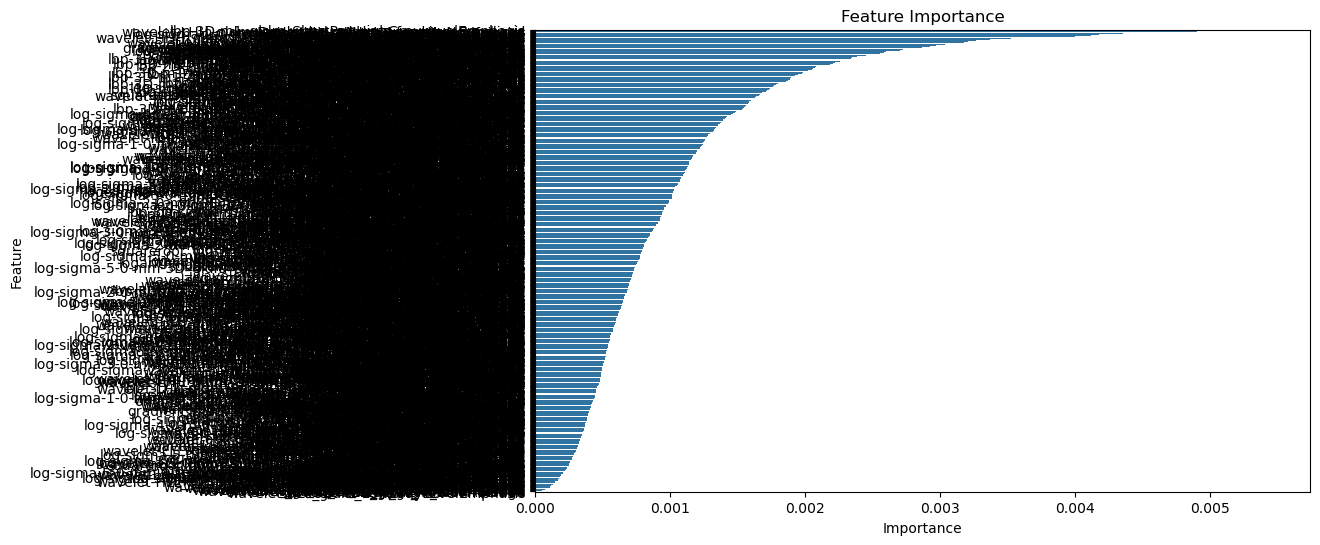

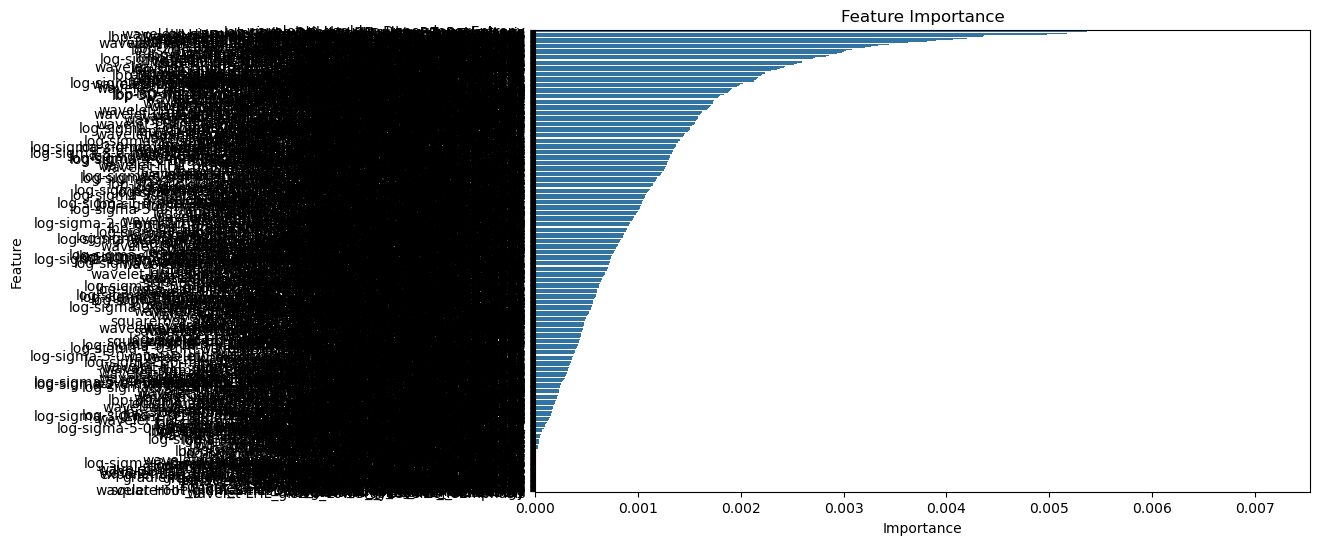

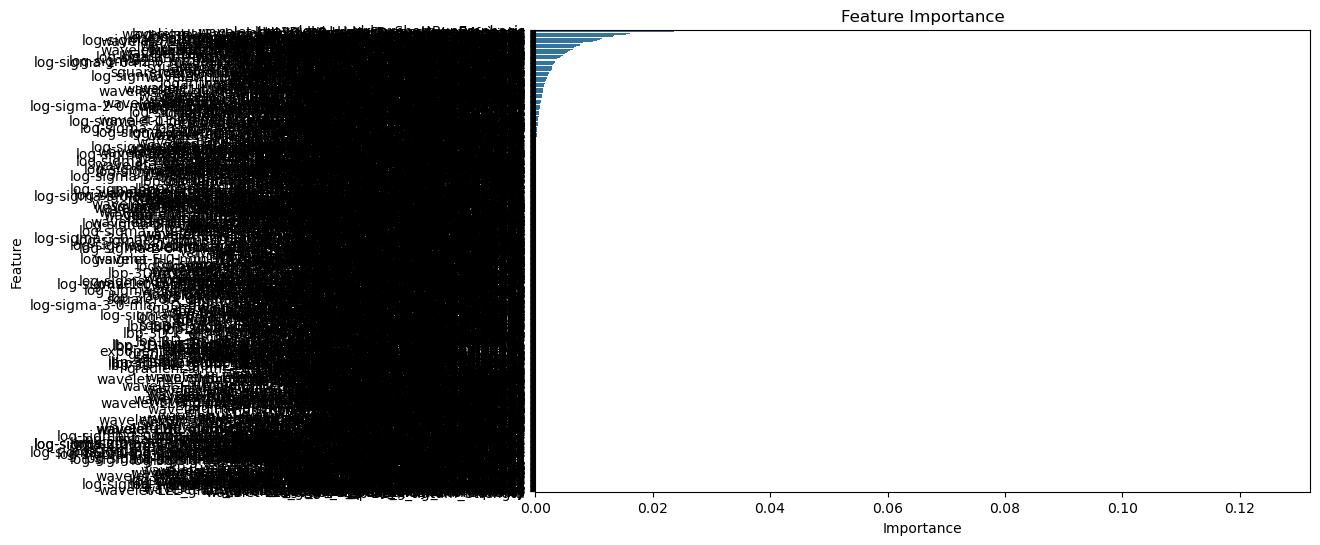

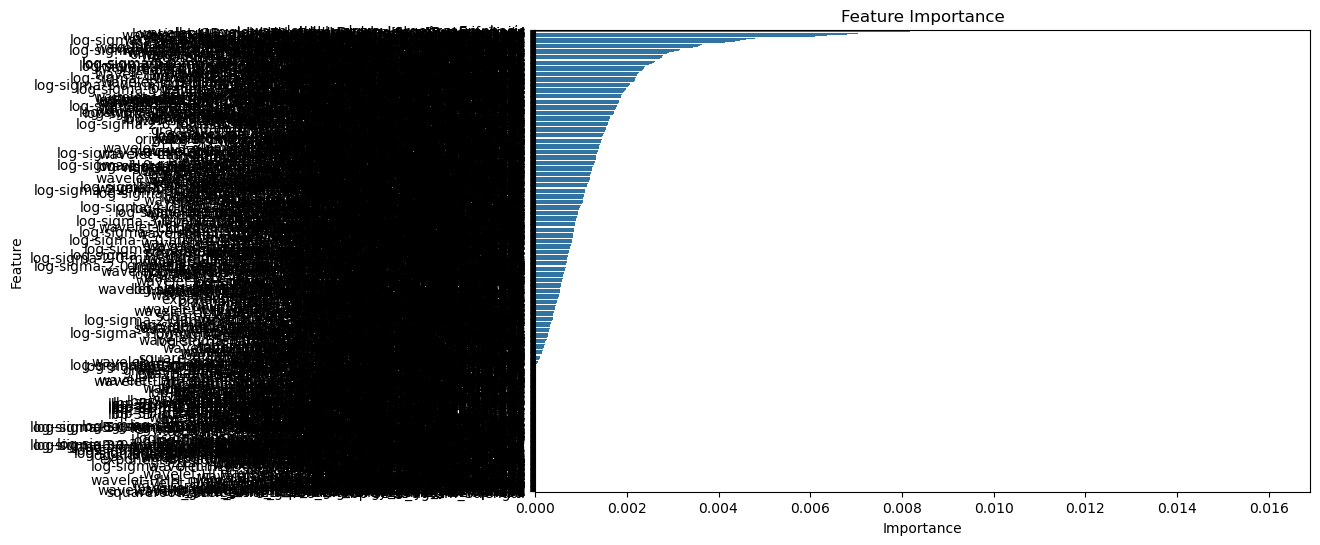

In [6]:
modelos = {
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=447, max_features='sqrt', max_depth=15,
        min_samples_split=10, min_samples_leaf=5, bootstrap=False, random_state=34
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=151, max_features='log2', max_depth=13,
        min_samples_split=10, min_samples_leaf=3, bootstrap=True, random_state=34
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.1, n_estimators=100, random_state=34
    ),
    "KNeighbors": KNeighborsClassifier(
        n_neighbors=5, weights='uniform', algorithm='auto'
    ),
    "SVC": SVC(
        kernel='rbf', random_state=34
    ),
    "XGBOOST" : XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)
}


for nome, modelo in modelos.items():
    # Chamar a função de processamento
    print(nome)
    report, f1_macro_score, f1_macro_std = gerar_origem(df, modelo,0.003)


In [7]:
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report


def gerar_origem_stacking(df, modelos, test_size=0.40, random_state=34, cv_folds=5):
    """
    Avalia um StackingClassifier usando os modelos fornecidos.
    
    Parâmetros:
        - df: DataFrame contendo os dados (incluindo 'Origem', 'Destino', 'Transition').
        - modelos: Dicionário de modelos base para o StackingClassifier.
        - test_size: Proporção do conjunto de teste (default: 0.40).
        - random_state: Semente para reprodutibilidade (default: 34).
        - cv_folds: Número de folds para cross-validation (default: 5).
        
    Retorna:
        - report_dict: Relatório de classificação (teste).
        - score_mean: Média das pontuações F1 (cross-validation).
        - score_std: Desvio padrão das pontuações F1 (cross-validation).
    """
    # Separar as features e os targets
    X = df.drop(columns=['Origem', 'Destino', 'Transition'])
    y_origem = df['Origem']
    y_transition = df['Transition']

    # Codificar as classes para y_origem e y_transition
    label_encoder_origem = LabelEncoder()
    y_origem_encoded = label_encoder_origem.fit_transform(y_origem)

    label_encoder_transition = LabelEncoder()
    y_transition_encoded = label_encoder_transition.fit_transform(y_transition)

    # Dividir o conjunto de dados em treino e teste para validação
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_origem_encoded, test_size=test_size, random_state=random_state, stratify=y_origem_encoded
    )

    # Converter o dicionário de modelos para estimators
    estimators = [(nome, modelo) for nome, modelo in modelos.items()]

    # Criar o StackingClassifier
    st_model = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(random_state=random_state)
    )

    # Avaliar desempenho com cross-validation no treino
    scores = cross_val_score(st_model, X_train, y_train, cv=cv_folds, scoring='f1_macro')
    print(f"F1 Macro (Cross-Validation): Média = {scores.mean():.4f}, Desvio = {scores.std():.4f}")

    # Treinar o modelo no conjunto de treino e prever no conjunto de teste
    st_model.fit(X_train, y_train)
    y_pred = st_model.predict(X_test)

    # Avaliar o desempenho no conjunto de teste
    print("\nRelatório de Classificação Stacking:")
    print(classification_report(y_test, y_pred))

    # Relatório de classificação como dicionário
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    return report_dict, scores.mean(), scores.std()


In [8]:
# Dicionário de modelos base
modelos = {
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=447, max_features='sqrt', max_depth=15,
        min_samples_split=10, min_samples_leaf=5, bootstrap=False, random_state=34
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=151, max_features='log2', max_depth=13,
        min_samples_split=10, min_samples_leaf=3, bootstrap=True, random_state=34
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.1, n_estimators=100, random_state=34
    ),
}

# Executar a função com o DataFrame `df`
relatorio, media_f1, desvio_f1 = gerar_origem_stacking(df, modelos)


F1 Macro (Cross-Validation): Média = 0.5023, Desvio = 0.0352

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.60      0.25      0.35        24
           1       0.63      0.76      0.69        42
           2       0.56      0.61      0.58        56

    accuracy                           0.59       122
   macro avg       0.59      0.54      0.54       122
weighted avg       0.59      0.59      0.57       122

